In [18]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [20]:
dataset_dir = r"C:\Users\NEHA.KOTA\Downloads\archive (1)\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 123


In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [23]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)  

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)  

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)  

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)  

In [24]:
print(class_names)            # ✅ instead of train_ds.class_names
print(len(class_names))       # ✅ use the saved variable


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


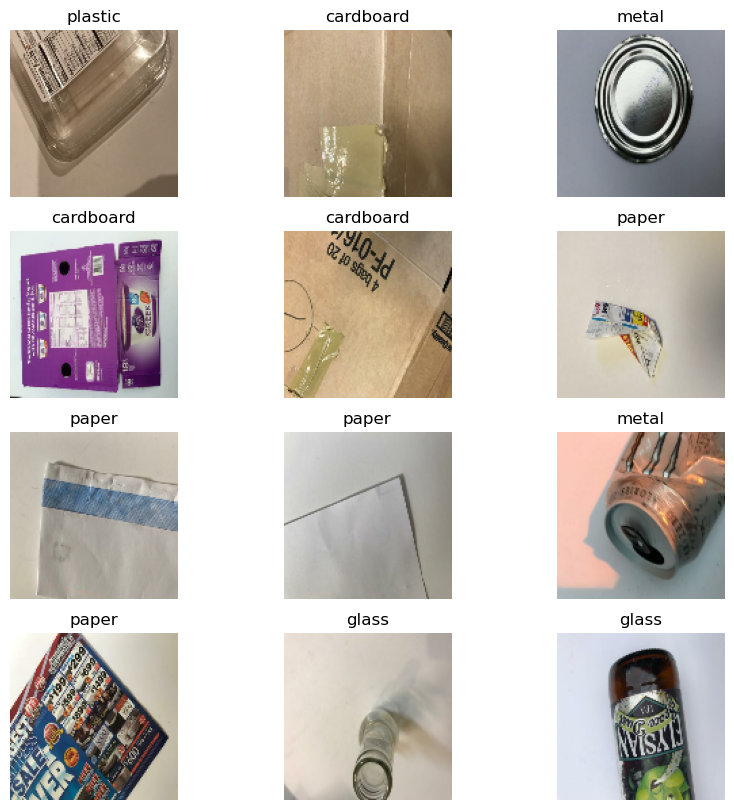

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [26]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [27]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [28]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 15.83, 'glass': 19.68, 'metal': 16.42, 'paper': 23.24, 'plastic': 19.49, 'trash': 5.34}
{'cardboard': 16.44, 'glass': 20.4, 'metal': 15.45, 'paper': 24.55, 'plastic': 17.43, 'trash': 5.74}
{'cardboard': 18.36, 'glass': 21.48, 'metal': 16.02, 'paper': 24.61, 'plastic': 13.28, 'trash': 6.25}
{'cardboard': 16.14, 'glass': 20.04, 'metal': 15.94, 'paper': 23.89, 'plastic': 18.46, 'trash': 5.54}


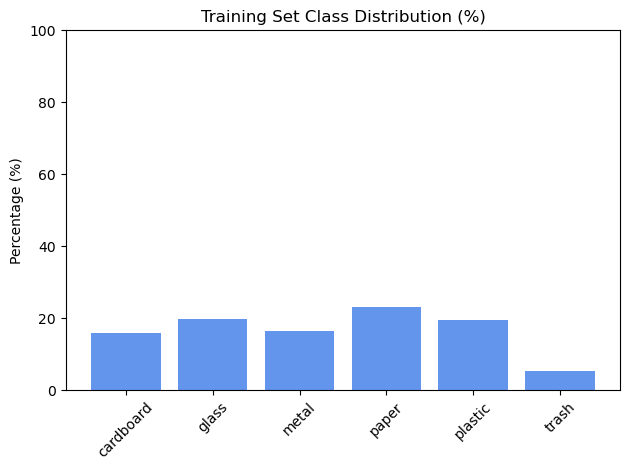

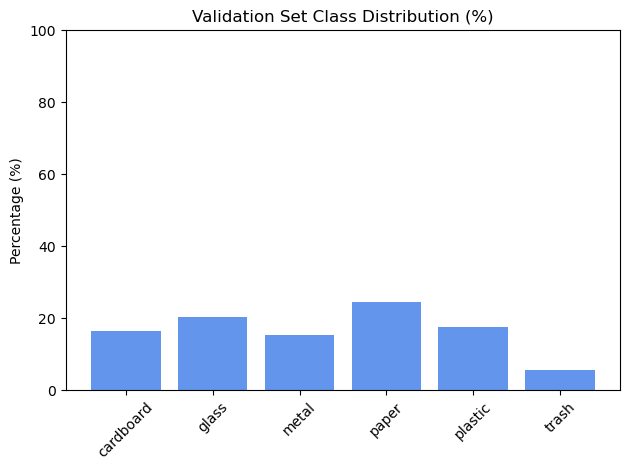

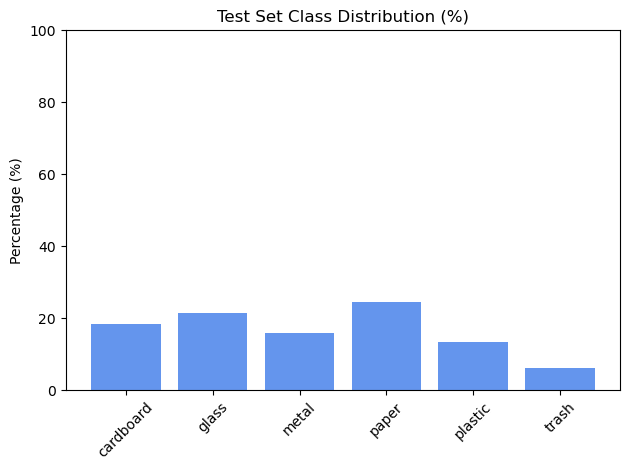

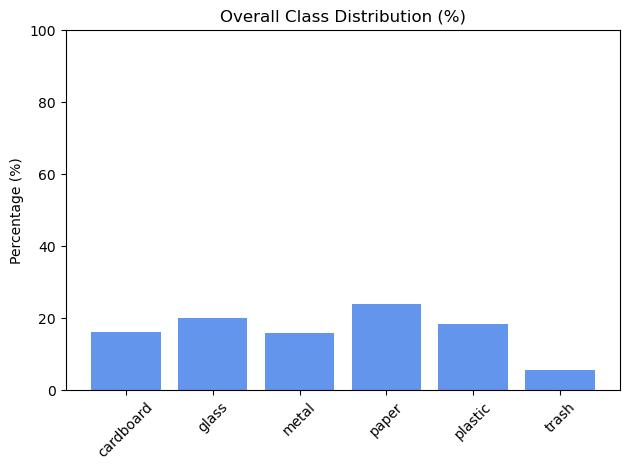

In [51]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [30]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        if isinstance(label, np.ndarray):  # handle one-hot encoded case
            label = np.argmax(label)
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),  # use actual labels present in the data
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in zip(np.unique(all_labels), class_weights_array)}

print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 320, 1: 398, 2: 332, 3: 470, 4: 394, 5: 108}
Class Weights: {0: 1.053125, 1: 0.8467336683417085, 2: 1.0150602409638554, 3: 0.7170212765957447, 4: 0.8553299492385786, 5: 3.1203703703703702}


In [31]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [32]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False



In [33]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])


In [34]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [35]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


In [36]:
# Fix class_weights to reindex from 0
label_mapping = {label: idx for idx, label in enumerate(sorted(set(all_labels)))}
mapped_labels = [label_mapping[label] for label in all_labels]

from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(label_mapping)),
    y=mapped_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 4, 4, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [38]:
%matplotlib inline

In [39]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights 
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 738ms/step - accuracy: 0.2651 - loss: 1.6974 - val_accuracy: 0.6416 - val_loss: 1.1620
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 669ms/step - accuracy: 0.6435 - loss: 1.0737 - val_accuracy: 0.7604 - val_loss: 0.8086
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 737ms/step - accuracy: 0.7469 - loss: 0.7388 - val_accuracy: 0.8178 - val_loss: 0.5992
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 661ms/step - accuracy: 0.8196 - loss: 0.5228 - val_accuracy: 0.8396 - val_loss: 0.4951
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 667ms/step - accuracy: 0.8704 - loss: 0.3943 - val_accuracy: 0.8713 - val_loss: 0.4047
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 594ms/step - accuracy: 0.8935 - loss: 0.3126 - val_accuracy: 0.8772 - val_loss: 0.3933
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 621ms/step - accuracy: 0.9216 - loss: 0.2544 - val_accuracy: 0.8931 - val_loss: 0.3616
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 671ms/step - accuracy: 0.9314 - loss: 0.2032 - val_accu

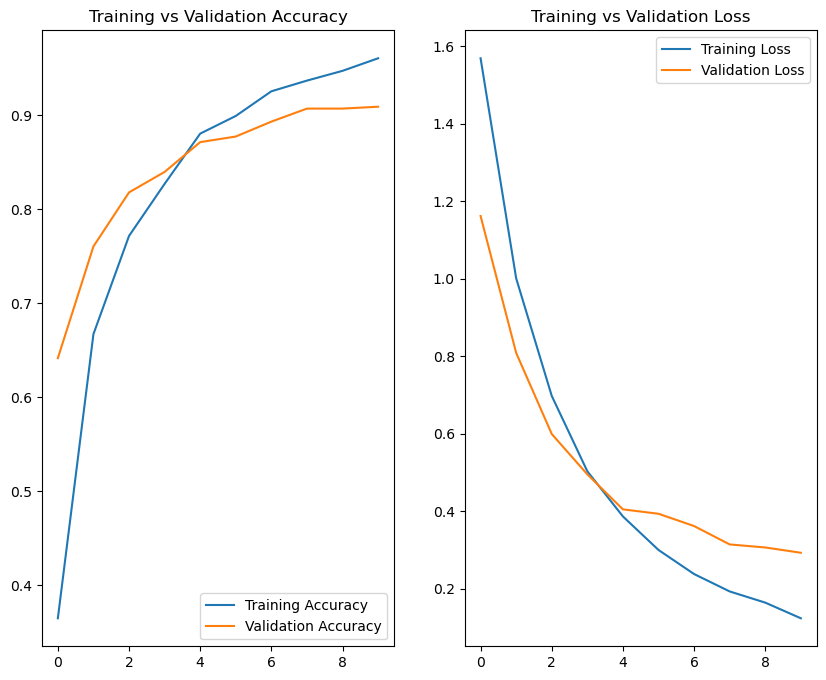

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


In [41]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.9257 - loss: 0.2852
Test accuracy is0.9258, Test loss is 0.2699


In [43]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step
[[33  0  0  2  0  0]
 [ 0 63  1  0  1  0]
 [ 0  2 37  0  0  0]
 [ 4  0  0 51  1  2]
 [ 0  2  0  0 40  1]
 [ 0  0  1  2  0 13]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        35
           1       0.94      0.97      0.95        65
           2       0.95      0.95      0.95        39
           3       0.93      0.88      0.90        58
           4       0.95      0.93      0.94        43
           5       0.81      0.81      0.81        16

    accuracy                           0.93       256
   macro avg       0.91      0.91      0.91       256
weighted avg       0.93      0.93      0.93       256



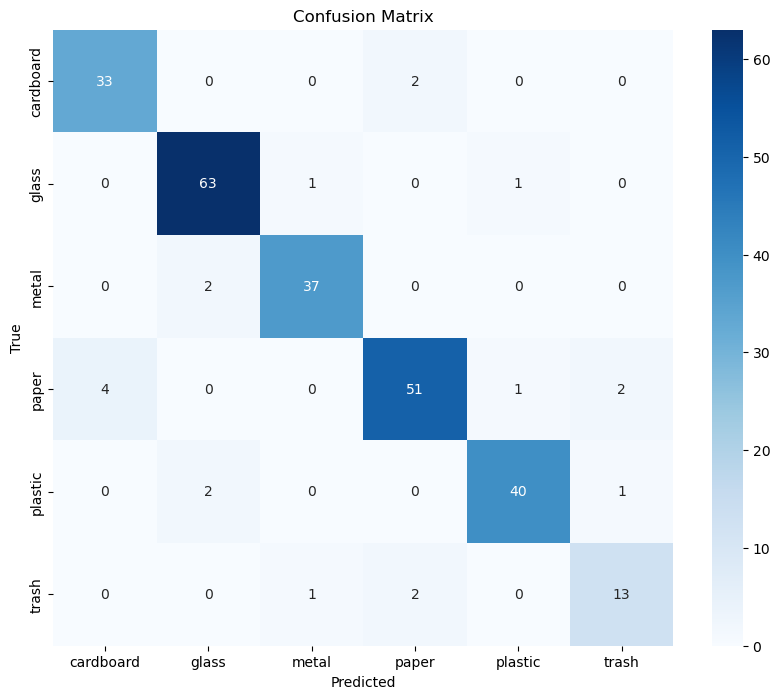

In [44]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


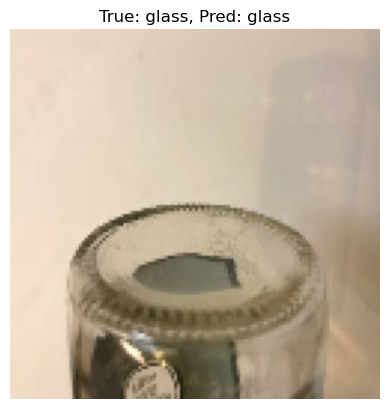

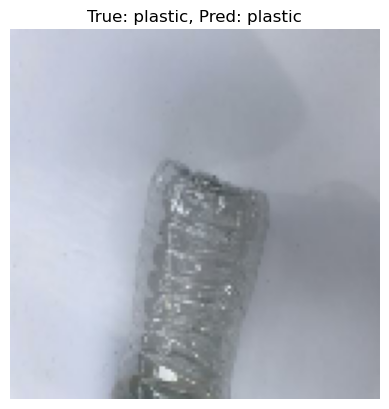

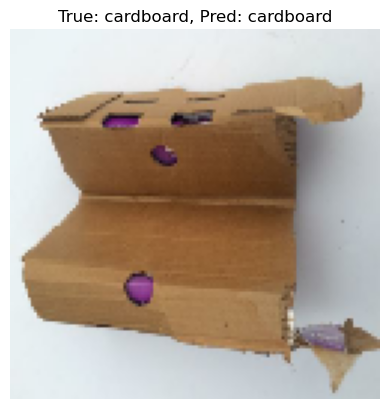

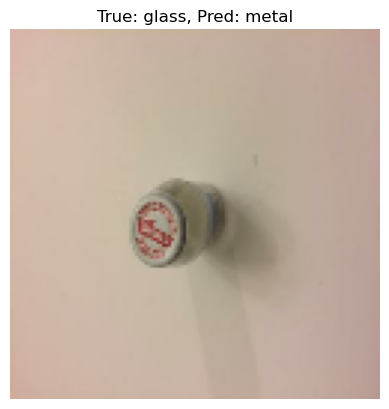

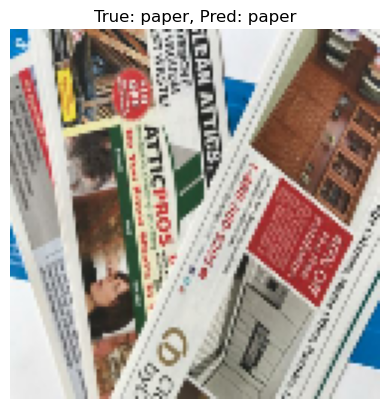

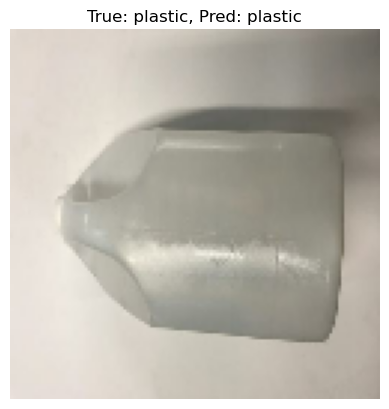

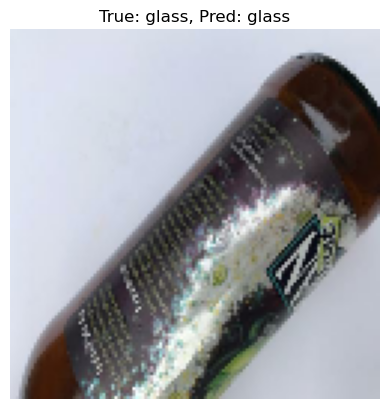

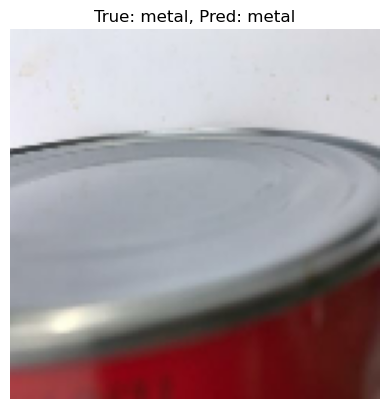

In [45]:
# Extract class names from the training dataset
class_names = train_ds.class_names  

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):  

    # Generate predictions for the batch of images
    predictions = model.predict(images)  

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)  

    # Loop through the first 8 images in the batch
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

In [46]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

In [47]:
#!pip install gradio

In [48]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [49]:
def classify_image(img):  
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))  
    
    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)  
    img_array = preprocess_input(img_array)
    
    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)  
    
    # Make a prediction using the trained model
    prediction = model.predict(img_array)  
    
    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)  
    
    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]  
    
    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]  
    
    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"  

In [50]:
iface = gr.Interface(  
    fn=classify_image,  # Function to classify image using the trained model  
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image  
    outputs="text"  # Outputs prediction as text  
)  

# Launch the interface  
iface.launch()  # Start the Gradio interface for user interaction  

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
